In [1]:
import os
import itertools
import time
import random

import numpy as np # linear algebra
from scipy import signal as sc
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import (CosineAnnealingLR,
                                      CosineAnnealingWarmRestarts,
                                      StepLR,
                                      ExponentialLR)
import torchvision
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score
from math import floor, ceil
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io
import os
from math import floor, ceil
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from matplotlib import colors
import seaborn as sns
from adabelief_pytorch import AdaBelief
from termcolor import colored


/home/benx13/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CustomImageDataset(Dataset):
  def __init__(self, labels_file, img_dir, transform=None):
    self.img_labels = scipy.io.loadmat(labels_file)['code_bdh'][0]
    self.img_dir = img_dir
    self.transform = transform
    self.imgs = [img for img in os.listdir(img_dir)]
    self.imgs.sort() 

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    image = Image.open(self.img_dir + '/' + self.imgs[idx])
    label = self.img_labels[idx] -1
    if self.transform:
      image = self.transform(image)
    return np.array(image), label

In [3]:
transform = T.Compose([
   T.Resize((224, 224)),
   T.ToTensor()
]) 
img_dir = 'data_2021/data_2021/png'
labels_file = 'data_2021/data_2021/code_bdh.mat'

In [4]:
dataset = CustomImageDataset(labels_file, img_dir, transform=transform) 
train_set, test_set = torch.utils.data.random_split(dataset, [floor(len(dataset) * 0.85), ceil(len(dataset)*0.15)])
train_loader = DataLoader(train_set, batch_size=64 , shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

In [5]:
for i in train_loader:
    print(i[0].shape)
    break

torch.Size([64, 3, 224, 224])


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [22]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 22)
model= nn.DataParallel(model)
model.to(device)
adam_belief = AdaBelief(model.parameters(), lr=1e-3, eps=1e-16, betas=(0.9,0.999), weight_decouple = True, rectify = False)
#adam = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
criterion = nn.CrossEntropyLoss()

/home/benx13/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/benx13/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief


In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

11187798

In [24]:
def overfit_single_batch(model=None, criterion=None, optimizer=None, train_loader=None, test_loader=None,epochs=64):
    # Train the model
    total_step = len(train_loader)
    train_loss = []
    train_acc = []
    i, (signal, labels) = next(enumerate(train_loader))
    signal = signal.to(device)
    labels = labels.to(device)

    for epoch in tqdm(range(epochs)):
        acc = []
        correct = 0
        total = 0

        # Forward pass
        outputs = model(signal)
        loss = criterion(outputs, labels)


        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, outputs = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (labels == outputs).sum() 
        acc.append((correct/total).item())


        #print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Acc: {:.4f}".format(epoch+1, epochs, i+1, total_step, loss.item(), np.mean(acc)))
        train_loss.append(loss.item())
        train_acc.append(np.mean(acc))
        


    return train_loss, train_acc

In [25]:
train_loss, train_acc = overfit_single_batch(model=model, criterion=criterion, optimizer=adam_belief, epochs=50, train_loader=train_loader, test_loader=test_loader)

100%|██████████| 50/50 [00:03<00:00, 13.63it/s]


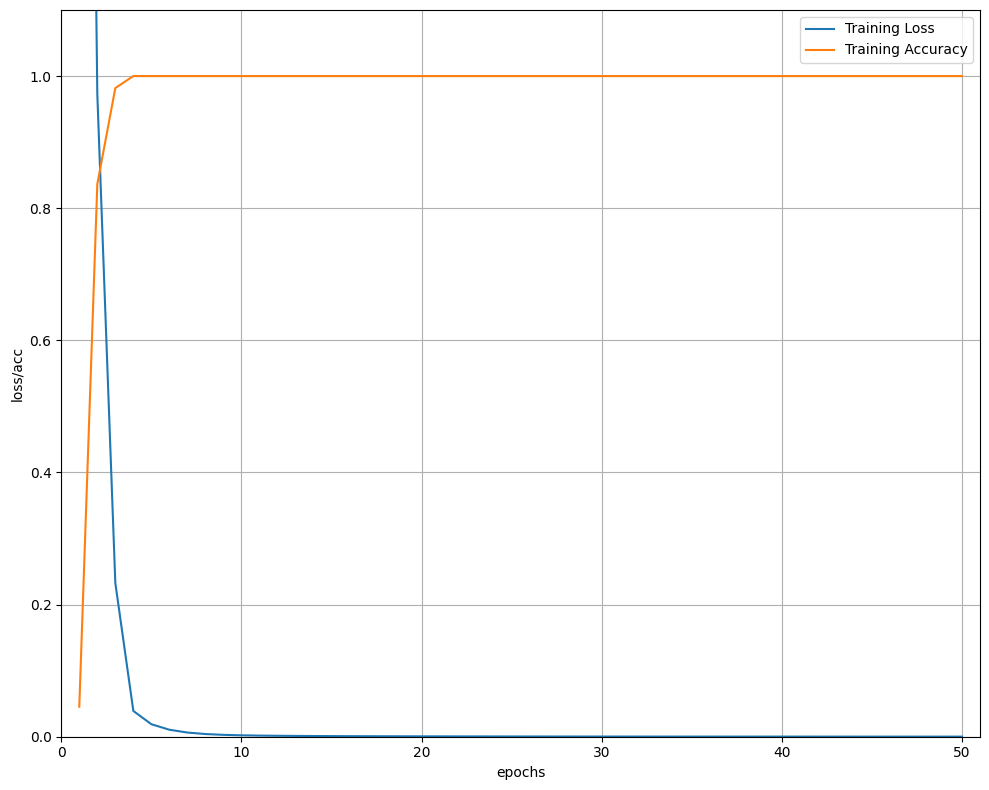

In [26]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(train_acc)+1),train_acc, label='Training Accuracy')

plt.xlabel('epochs')
plt.ylabel('loss/acc')
plt.ylim(0, 1.1) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
def train(model=None, criterion=None, optimizer=None, train_loader=None, test_loader=None,epochs=64):
    # Train the model
    total_step = len(train_loader)
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    conf_mats = []
    val_loss_min = 1
    bar = tqdm(range(epochs))
    for epoch in bar:
        acc = []
        correct = 0
        total = 0  
        # Training step
        for i, (signal, labels) in enumerate(train_loader):
            signal = signal.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(signal)

            loss = criterion(outputs, labels)


            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, outputs = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (labels == outputs).sum() 
            acc.append((correct/total).item())

        #print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Acc: {:.4f}".format(epoch+1, epochs, i+1, total_step, loss.item(), np.mean(acc)))
        train_loss.append(loss.item())
        train_acc.append(np.mean(acc))

        # Validation step
        correct = 0
        total = 0  
        v_loss = []
        v_acc = []
        confusion_matrix = torch.zeros(22, 22)
        for signal, labels in test_loader:
            signal = signal.to(device)
            labels = labels.to(device)
            predictions = model(signal)
            _, predicted = torch.max(predictions, 1)
            total += labels.size(0) 
            correct += (labels == predicted).sum() 
            loss = criterion(predictions, labels)
            v_loss.append(loss.item())
            v_acc.append((correct/total).item())

            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            conf_mats.append(confusion_matrix)

        bar.set_postfix({'\033[91m Val Loss:': np.mean(v_loss), '\033[92m Val Acc:': float(correct/total),"\033[0m \n":""})
        #print('\033[91m Val Loss: '+str(np.mean(v_loss)), '\033[92m  Val Acc: '+ str(correct/total), "")

        val_acc.append((correct/total).item())
        val_loss.append(np.mean(v_loss))

        
        train_history = {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'confusion_matrix':conf_mats
        }


    return train_history, model

In [28]:
t_h, model = train(model=model, criterion=criterion, optimizer=adam_belief, epochs=50, train_loader=train_loader, test_loader=test_loader)

  0%|          | 0/50 [00:09<?, ?it/s,  Val Loss:=0.0508,  Val Acc:=0.986,  
  2%|▏         | 1/50 [00:09<08:02,  9.85s/it,  Val Loss:=0.0508,  Val Acc:=0.986,  
  2%|▏         | 1/50 [00:19<08:02,  9.85s/it,  Val Loss:=0.0525,  Val Acc:=0.988,  
  4%|▍         | 2/50 [00:19<07:49,  9.79s/it,  Val Loss:=0.0525,  Val Acc:=0.988,  
  4%|▍         | 2/50 [00:29<07:49,  9.79s/it,  Val Loss:=0.0252,  Val Acc:=0.99,  
  6%|▌         | 3/50 [00:29<07:53, 10.07s/it,  Val Loss:=0.0252,  Val Acc:=0.99,  
  6%|▌         | 3/50 [00:40<07:53, 10.07s/it,  Val Loss:=0.0147,  Val Acc:=0.996,  
  8%|▊         | 4/50 [00:40<07:47, 10.17s/it,  Val Loss:=0.0147,  Val Acc:=0.996,  
  8%|▊         | 4/50 [00:50<07:47, 10.17s/it,  Val Loss:=0.0599,  Val Acc:=0.982,  
 10%|█         | 5/50 [00:50<07:36, 10.15s/it,  Val Loss:=0.0599,  Val Acc:=0.982,  
 10%|█         | 5/50 [01:00<07:36, 10.15s/it,  Val Loss:=0.05,  Val Acc:=0.981,  
 12%|█▏        | 6/50 [01:00<07:23, 10.08s/it,  Val Loss:=0.05,  Val Acc:=0.9

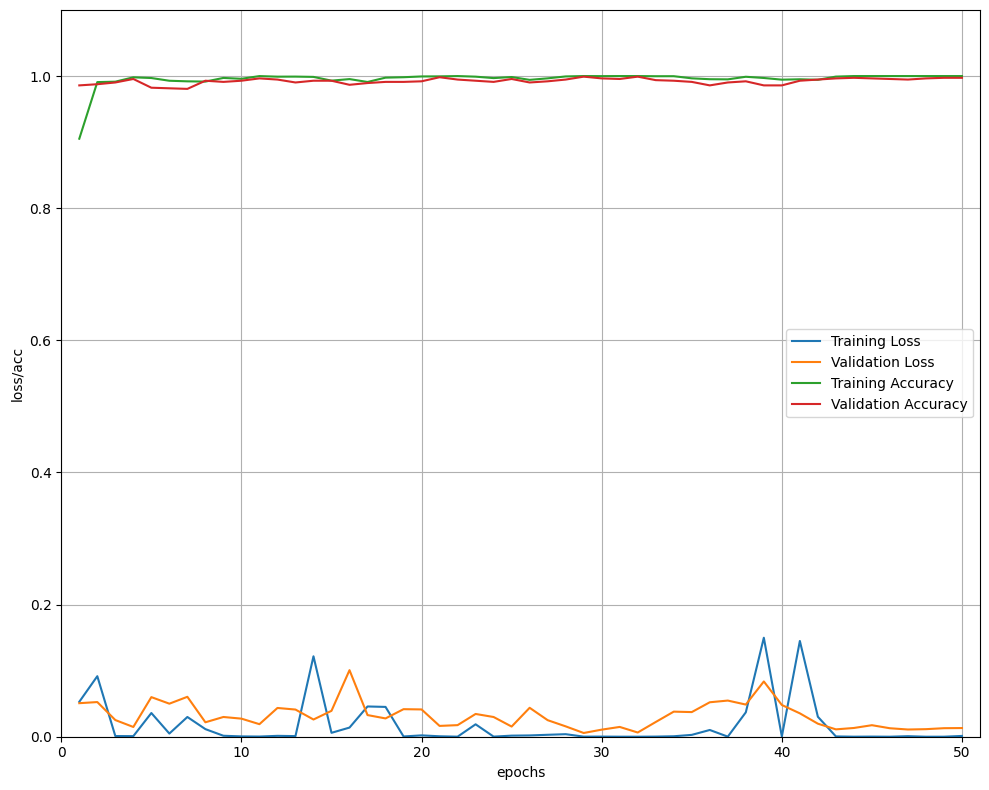

In [29]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(t_h['train_loss'])+1),t_h['train_loss'], label='Training Loss')
plt.plot(range(1,len(t_h['val_loss'])+1),t_h['val_loss'],label='Validation Loss')
plt.plot(range(1,len(t_h['train_acc'])+1),t_h['train_acc'], label='Training Accuracy')
plt.plot(range(1,len(t_h['val_acc'])+1),t_h['val_acc'],label='Validation Accuracy')


plt.xlabel('epochs')
plt.ylabel('loss/acc')
plt.ylim(0, 1.1) # consistent scale
plt.xlim(0, len(t_h['train_loss'])+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
flatten = lambda t: [item for sublist in t for item in sublist]

y_pred_list = []
y_test_list = []
with torch.no_grad():
    model.eval()
    for X_batch, y_tag in tqdm(test_loader):
        #print(y_tag.tolist())
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        #print(F.softmax(y_test_pred, dim=1))
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
        y_test_list.append(y_tag)
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_pred_list = flatten(y_pred_list)
y_test_list = flatten(y_test_list)

100%|██████████| 11/11 [00:01<00:00, 10.36it/s]


<AxesSubplot: >

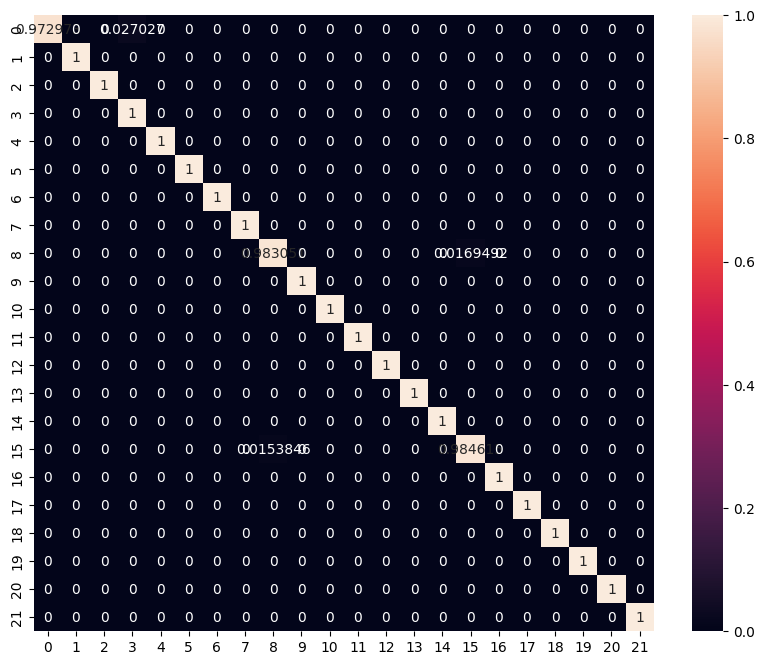

In [31]:
cm = confusion_matrix(np.array(y_test_list),np.array(y_pred_list))
cm = cm/cm.sum(axis=1)[:,None]
confusion_matrix_df = pd.DataFrame(cm)
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix_df, annot=True, fmt='g')

In [32]:
print(classification_report(y_test_list, y_pred_list, digits=4))


              precision    recall  f1-score   support

           0     1.0000    0.9730    0.9863        37
           1     1.0000    1.0000    1.0000        58
           2     1.0000    1.0000    1.0000        53
           3     0.9804    1.0000    0.9901        50
           4     1.0000    1.0000    1.0000        45
           5     1.0000    1.0000    1.0000        50
           6     1.0000    1.0000    1.0000        55
           7     1.0000    1.0000    1.0000        48
           8     0.9831    0.9831    0.9831        59
           9     1.0000    1.0000    1.0000        37
          10     1.0000    1.0000    1.0000        57
          11     1.0000    1.0000    1.0000        58
          12     1.0000    1.0000    1.0000        47
          13     1.0000    1.0000    1.0000        43
          14     1.0000    1.0000    1.0000        47
          15     0.9846    0.9846    0.9846        65
          16     1.0000    1.0000    1.0000        51
          17     1.0000    

In [33]:
from efficientnet_pytorch import EfficientNet
torchvision.models.efficientnet_v2_l

<function torchvision.models.efficientnet.efficientnet_v2_l(*, weights: Optional[torchvision.models.efficientnet.EfficientNet_V2_L_Weights] = None, progress: bool = True, **kwargs: Any) -> torchvision.models.efficientnet.EfficientNet>

In [34]:
from torch.nn.parallel import DistributedDataParallel as DDP


In [7]:
model = model = torchvision.models.efficientnet_b0(pretrained=True)
model.fc = nn.Linear(512, 22)
model= nn.DataParallel(model)
model.to(device)
adam_belief = AdaBelief(model.parameters(), lr=1e-3, eps=1e-16, betas=(0.9,0.999), weight_decouple = True, rectify = False)
#adam = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
criterion = nn.CrossEntropyLoss()

/home/benx13/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/benx13/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief


In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

5299834

In [9]:
def train_single_batch(model=None, criterion=None, optimizer=None, train_loader=None, test_loader=None,epochs=64):
    # Train the model
    total_step = len(train_loader)
    train_loss = []
    train_acc = []
    i, (signal, labels) = next(enumerate(train_loader))
    signal = signal.to(device)
    labels = labels.to(device)

    for epoch in tqdm(range(epochs)):
        acc = []
        correct = 0
        total = 0

        # Forward pass
        outputs = model(signal)
        loss = criterion(outputs, labels)


        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, outputs = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (labels == outputs).sum() 
        acc.append((correct/total).item())


        #print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Acc: {:.4f}".format(epoch+1, epochs, i+1, total_step, loss.item(), np.mean(acc)))
        train_loss.append(loss.item())
        train_acc.append(np.mean(acc))
        


    return train_loss, train_acc

In [10]:
train_loss, train_acc = train_single_batch(model=model, criterion=criterion, optimizer=adam_belief, epochs=50, train_loader=train_loader, test_loader=test_loader)

100%|██████████| 50/50 [00:16<00:00,  3.07it/s]


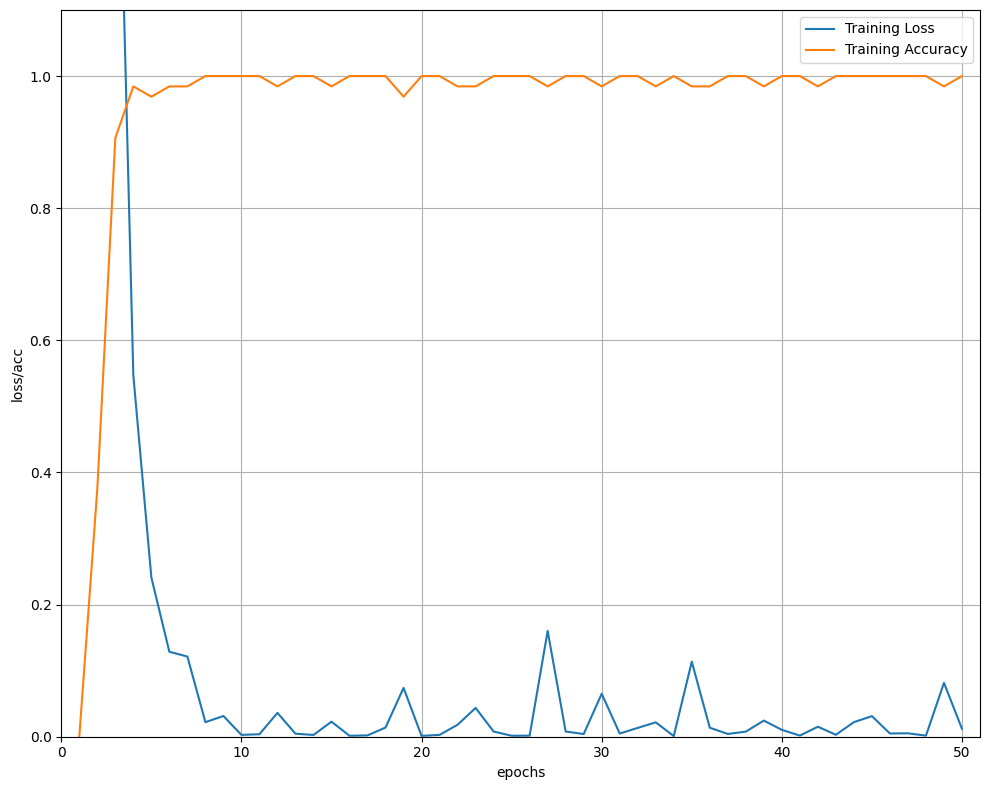

In [11]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(train_acc)+1),train_acc, label='Training Accuracy')

plt.xlabel('epochs')
plt.ylabel('loss/acc')
plt.ylim(0, 1.1) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
def train(model=None, criterion=None, optimizer=None, train_loader=None, test_loader=None,epochs=64):
    # Train the model
    total_step = len(train_loader)
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    conf_mats = []
    val_loss_min = 1
    bar = tqdm(range(epochs))
    for epoch in bar:
        acc = []
        correct = 0
        total = 0  
        # Training step
        for i, (signal, labels) in enumerate(train_loader):
            signal = signal.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(signal)

            loss = criterion(outputs, labels)


            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, outputs = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (labels == outputs).sum() 
            acc.append((correct/total).item())

        #print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Acc: {:.4f}".format(epoch+1, epochs, i+1, total_step, loss.item(), np.mean(acc)))
        train_loss.append(loss.item())
        train_acc.append(np.mean(acc))

        # Validation step
        correct = 0
        total = 0  
        v_loss = []
        v_acc = []
        confusion_matrix = torch.zeros(22, 22)
        for signal, labels in test_loader:
            signal = signal.to(device)
            labels = labels.to(device)
            predictions = model(signal)
            _, predicted = torch.max(predictions, 1)
            total += labels.size(0) 
            correct += (labels == predicted).sum() 
            loss = criterion(predictions, labels)
            v_loss.append(loss.item())
            v_acc.append((correct/total).item())

            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            conf_mats.append(confusion_matrix)

        bar.set_postfix({'\033[91m Val Loss:': np.mean(v_loss), '\033[92m Val Acc:': float(correct/total),"\033[0m \n":""})
        #print('\033[91m Val Loss: '+str(np.mean(v_loss)), '\033[92m  Val Acc: '+ str(correct/total), "")

        val_acc.append((correct/total).item())
        val_loss.append(np.mean(v_loss))

        
        train_history = {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'confusion_matrix':conf_mats
        }


    return train_history, model

In [13]:
t_h, model = train(model=model, criterion=criterion, optimizer=adam_belief, epochs=50, train_loader=train_loader, test_loader=test_loader)

  0%|          | 0/50 [00:40<?, ?it/s,  Val Loss:=0.0379,  Val Acc:=0.992,  
  2%|▏         | 1/50 [00:40<32:49, 40.19s/it,  Val Loss:=0.0379,  Val Acc:=0.992,  
  2%|▏         | 1/50 [01:19<32:49, 40.19s/it,  Val Loss:=0.0365,  Val Acc:=0.989,  
  4%|▍         | 2/50 [01:19<31:45, 39.70s/it,  Val Loss:=0.0365,  Val Acc:=0.989,  
  4%|▍         | 2/50 [01:56<31:45, 39.70s/it,  Val Loss:=0.0212,  Val Acc:=0.993,  
  6%|▌         | 3/50 [01:56<30:17, 38.66s/it,  Val Loss:=0.0212,  Val Acc:=0.993,  
  6%|▌         | 3/50 [02:34<30:17, 38.66s/it,  Val Loss:=0.0306,  Val Acc:=0.991,  
  8%|▊         | 4/50 [02:34<29:17, 38.20s/it,  Val Loss:=0.0306,  Val Acc:=0.991,  
  8%|▊         | 4/50 [03:12<29:17, 38.20s/it,  Val Loss:=0.0276,  Val Acc:=0.991,  
 10%|█         | 5/50 [03:12<28:30, 38.01s/it,  Val Loss:=0.0276,  Val Acc:=0.991,  
 10%|█         | 5/50 [03:49<28:30, 38.01s/it,  Val Loss:=0.0206,  Val Acc:=0.993,  
 12%|█▏        | 6/50 [03:49<27:48, 37.92s/it,  Val Loss:=0.0206,  Val Ac

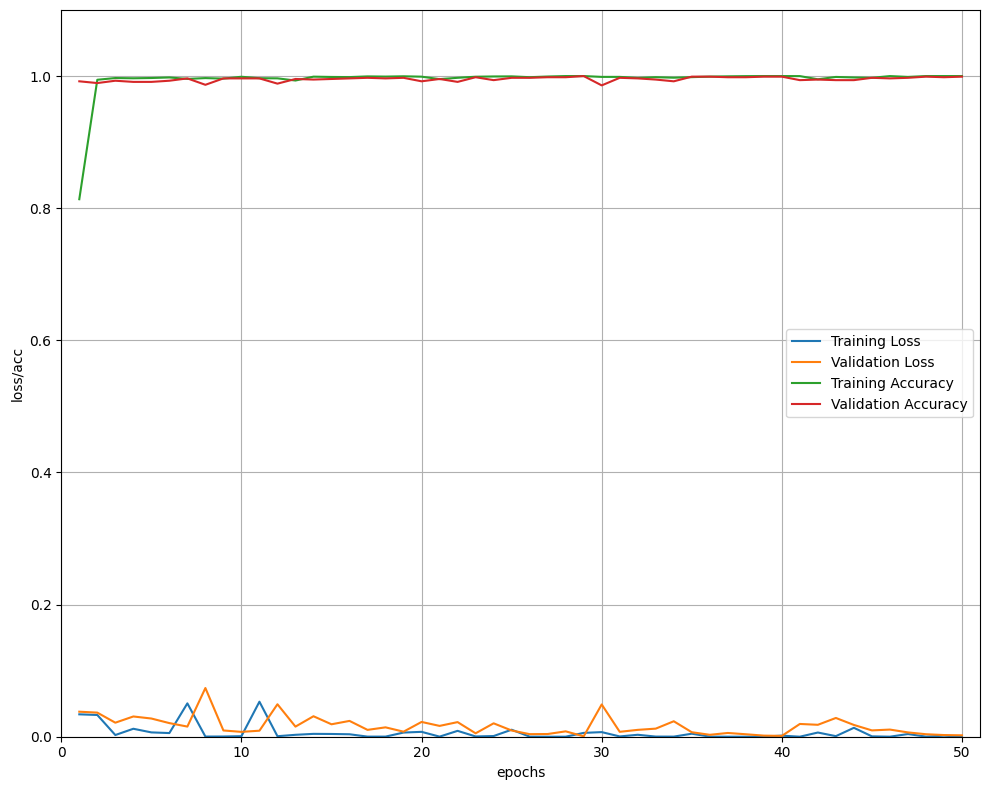

In [18]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(t_h['train_loss'])+1),t_h['train_loss'], label='Training Loss')
plt.plot(range(1,len(t_h['val_loss'])+1),t_h['val_loss'],label='Validation Loss')
plt.plot(range(1,len(t_h['train_acc'])+1),t_h['train_acc'], label='Training Accuracy')
plt.plot(range(1,len(t_h['val_acc'])+1),t_h['val_acc'],label='Validation Accuracy')


plt.xlabel('epochs')
plt.ylabel('loss/acc')
plt.ylim(0, 1.1) # consistent scale
plt.xlim(0, len(t_h['train_loss'])+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
flatten = lambda t: [item for sublist in t for item in sublist]

y_pred_list = []
y_test_list = []
with torch.no_grad():
    model.eval()
    for X_batch, y_tag in tqdm(test_loader):
        #print(y_tag.tolist())
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        #print(F.softmax(y_test_pred, dim=1))
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
        y_test_list.append(y_tag)
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_pred_list = flatten(y_pred_list)
y_test_list = flatten(y_test_list)

100%|██████████| 18/18 [00:03<00:00,  5.80it/s]


<AxesSubplot: >

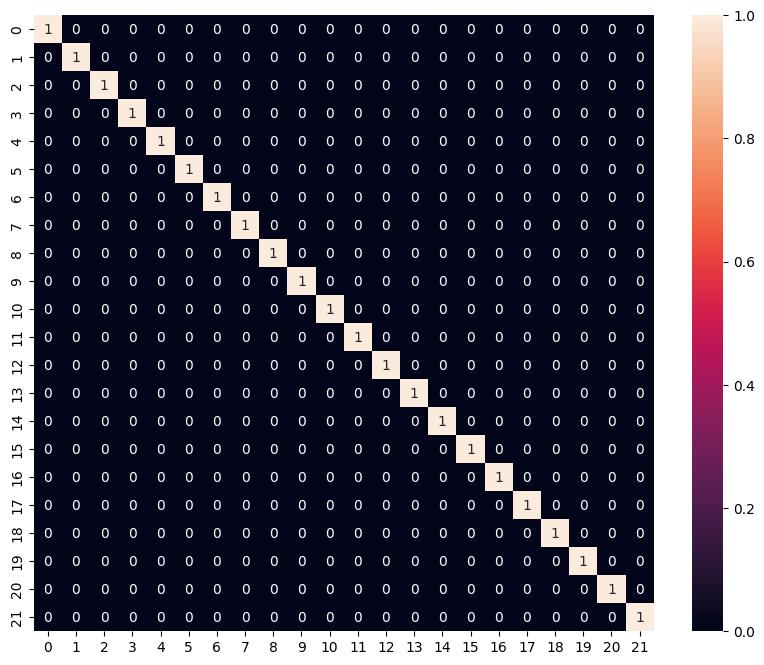

In [20]:
cm = confusion_matrix(np.array(y_test_list),np.array(y_pred_list))
cm = cm/cm.sum(axis=1)[:,None]
confusion_matrix_df = pd.DataFrame(cm)
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix_df, annot=True, fmt='g')

In [21]:
print(classification_report(y_test_list, y_pred_list, digits=4))


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        45
           1     1.0000    1.0000    1.0000        47
           2     1.0000    1.0000    1.0000        56
           3     1.0000    1.0000    1.0000        50
           4     1.0000    1.0000    1.0000        52
           5     1.0000    1.0000    1.0000        48
           6     1.0000    1.0000    1.0000        53
           7     1.0000    1.0000    1.0000        63
           8     1.0000    1.0000    1.0000        60
           9     1.0000    1.0000    1.0000        42
          10     1.0000    1.0000    1.0000        41
          11     1.0000    1.0000    1.0000        46
          12     1.0000    1.0000    1.0000        60
          13     1.0000    1.0000    1.0000        55
          14     1.0000    1.0000    1.0000        45
          15     1.0000    1.0000    1.0000        65
          16     1.0000    1.0000    1.0000        50
          17     1.0000    

In [22]:
torch.save(model.state_dict(), 'efficientNetB0_100acc.pt')

In [7]:
import torchvision.transforms as transforms


In [8]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_small_patch16_224', pretrained=True)
model.fc = nn.Linear(512, 22)
model= nn.DataParallel(model)
model.to(device)
adam_belief = AdaBelief(model.parameters(), lr=1e-3, eps=1e-16, betas=(0.9,0.999), weight_decouple = True, rectify = False)
#adam = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
criterion = nn.CrossEntropyLoss()

Using cache found in /home/benx13/.cache/torch/hub/facebookresearch_deit_main


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief


In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

22061950

In [9]:
def train_single_batch(model=None, criterion=None, optimizer=None, train_loader=None, test_loader=None,epochs=64):
    # Train the model
    total_step = len(train_loader)
    train_loss = []
    train_acc = []
    i, (signal, labels) = next(enumerate(train_loader))
    signal = signal.to(device)
    labels = labels.to(device)

    for epoch in tqdm(range(epochs)):
        acc = []
        correct = 0
        total = 0

        # Forward pass
        outputs = model(signal)
        loss = criterion(outputs, labels)


        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, outputs = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (labels == outputs).sum() 
        acc.append((correct/total).item())


        #print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Acc: {:.4f}".format(epoch+1, epochs, i+1, total_step, loss.item(), np.mean(acc)))
        train_loss.append(loss.item())
        train_acc.append(np.mean(acc))
        


    return train_loss, train_acc

In [10]:
train_loss, train_acc = train_single_batch(model=model, criterion=criterion, optimizer=adam_belief, epochs=500, train_loader=train_loader, test_loader=test_loader)

  1%|          | 6/500 [00:04<04:16,  1.93it/s]

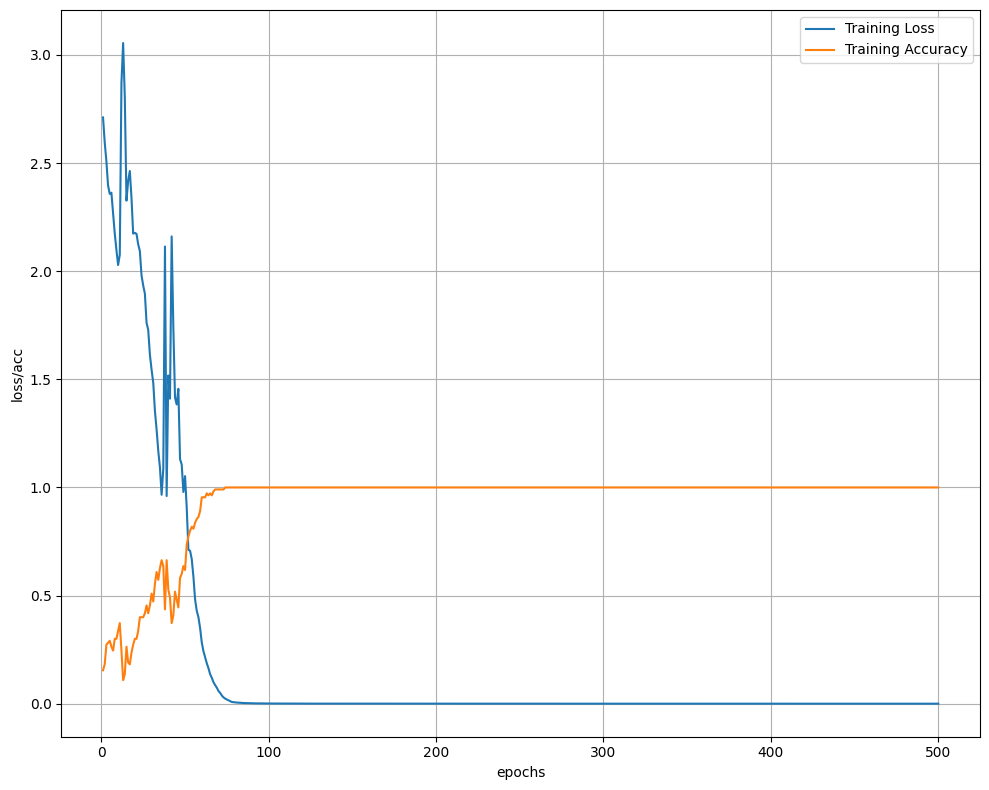

In [ ]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(train_acc)+1),train_acc, label='Training Accuracy')

plt.xlabel('epochs')
plt.ylabel('loss/acc')
#plt.ylim(0, 1.1) # consistent scale
#plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
def train(model=None, criterion=None, optimizer=None, train_loader=None, test_loader=None,epochs=64):
    # Train the model
    total_step = len(train_loader)
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    conf_mats = []
    val_loss_min = 1
    bar = tqdm(range(epochs))
    for epoch in bar:
        acc = []
        correct = 0
        total = 0  
        # Training step
        for i, (signal, labels) in enumerate(train_loader):
            signal = signal.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(signal)

            loss = criterion(outputs, labels)


            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, outputs = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (labels == outputs).sum() 
            acc.append((correct/total).item())

        #print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Acc: {:.4f}".format(epoch+1, epochs, i+1, total_step, loss.item(), np.mean(acc)))
        train_loss.append(loss.item())
        train_acc.append(np.mean(acc))

        # Validation step
        correct = 0
        total = 0  
        v_loss = []
        v_acc = []
        confusion_matrix = torch.zeros(22, 22)
        for signal, labels in test_loader:
            signal = signal.to(device)
            labels = labels.to(device)
            predictions = model(signal)
            _, predicted = torch.max(predictions, 1)
            total += labels.size(0) 
            correct += (labels == predicted).sum() 
            loss = criterion(predictions, labels)
            v_loss.append(loss.item())
            v_acc.append((correct/total).item())

            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            conf_mats.append(confusion_matrix)

        bar.set_postfix({'\033[91m Val Loss:': np.mean(v_loss), '\033[92m Val Acc:': float(correct/total),"\033[0m \n":""})
        #print('\033[91m Val Loss: '+str(np.mean(v_loss)), '\033[92m  Val Acc: '+ str(correct/total), "")

        val_acc.append((correct/total).item())
        val_loss.append(np.mean(v_loss))

        
        train_history = {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'confusion_matrix':conf_mats
        }


    return train_history, model

In [11]:
t_h, model = train(model=model, criterion=criterion, optimizer=adam_belief, epochs=50, train_loader=train_loader, test_loader=test_loader)

  0%|          | 0/50 [00:58<?, ?it/s,  Val Loss:=2.34,  Val Acc:=0.211,  
  2%|▏         | 1/50 [00:58<48:00, 58.78s/it,  Val Loss:=2.34,  Val Acc:=0.211,  
  2%|▏         | 1/50 [01:56<48:00, 58.78s/it,  Val Loss:=1.45,  Val Acc:=0.501,  
  4%|▍         | 2/50 [01:56<46:20, 57.93s/it,  Val Loss:=1.45,  Val Acc:=0.501,  
  4%|▍         | 2/50 [02:51<46:20, 57.93s/it,  Val Loss:=0.622,  Val Acc:=0.787,  
  6%|▌         | 3/50 [02:51<44:38, 56.99s/it,  Val Loss:=0.622,  Val Acc:=0.787,  
  6%|▌         | 3/50 [03:48<44:38, 56.99s/it,  Val Loss:=0.352,  Val Acc:=0.885,  
  8%|▊         | 4/50 [03:48<43:34, 56.83s/it,  Val Loss:=0.352,  Val Acc:=0.885,  
  8%|▊         | 4/50 [04:45<43:34, 56.83s/it,  Val Loss:=0.428,  Val Acc:=0.854,  
 10%|█         | 5/50 [04:45<42:39, 56.89s/it,  Val Loss:=0.428,  Val Acc:=0.854,  
 10%|█         | 5/50 [05:42<42:39, 56.89s/it,  Val Loss:=0.266,  Val Acc:=0.922,  
 12%|█▏        | 6/50 [05:42<41:42, 56.86s/it,  Val Loss:=0.266,  Val Acc:=0.922,  
 12%

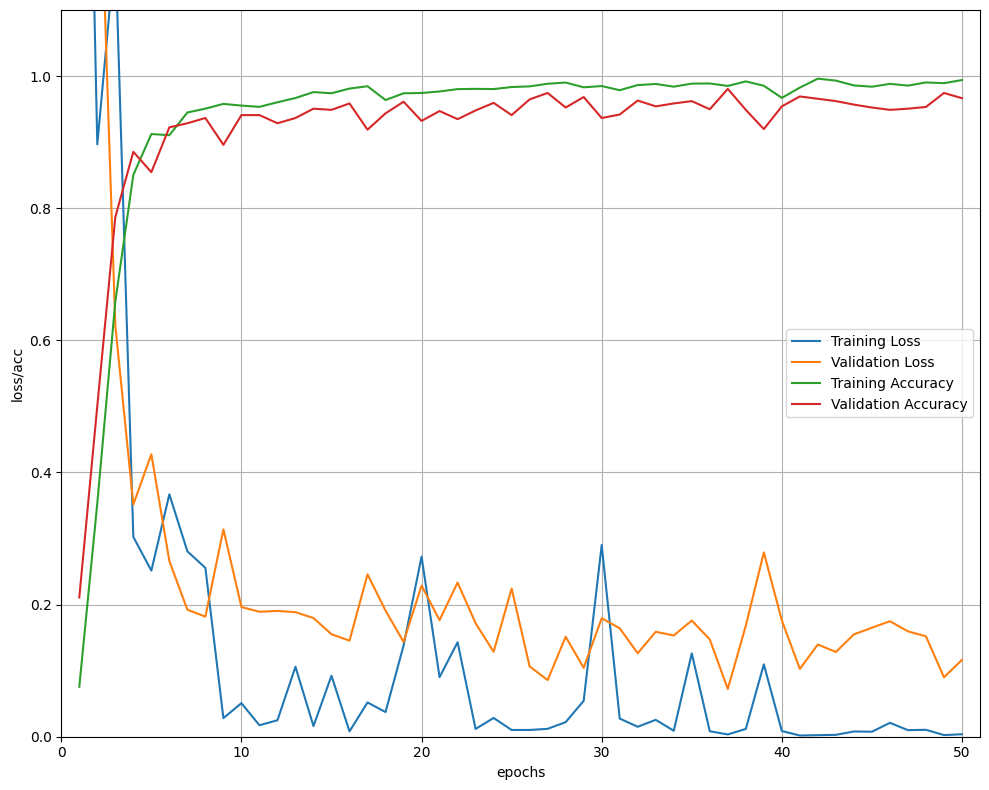

In [14]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(t_h['train_loss'])+1),t_h['train_loss'], label='Training Loss')
plt.plot(range(1,len(t_h['val_loss'])+1),t_h['val_loss'],label='Validation Loss')
plt.plot(range(1,len(t_h['train_acc'])+1),t_h['train_acc'], label='Training Accuracy')
plt.plot(range(1,len(t_h['val_acc'])+1),t_h['val_acc'],label='Validation Accuracy')


plt.xlabel('epochs')
plt.ylabel('loss/acc')
plt.ylim(0, 1.1) # consistent scale
plt.xlim(0, len(t_h['train_loss'])+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
flatten = lambda t: [item for sublist in t for item in sublist]

y_pred_list = []
y_test_list = []
with torch.no_grad():
    model.eval()
    for X_batch, y_tag in tqdm(test_loader):
        #print(y_tag.tolist())
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        #print(F.softmax(y_test_pred, dim=1))
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
        y_test_list.append(y_tag)
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_pred_list = flatten(y_pred_list)
y_test_list = flatten(y_test_list)

100%|██████████| 18/18 [00:05<00:00,  3.37it/s]


<AxesSubplot: >

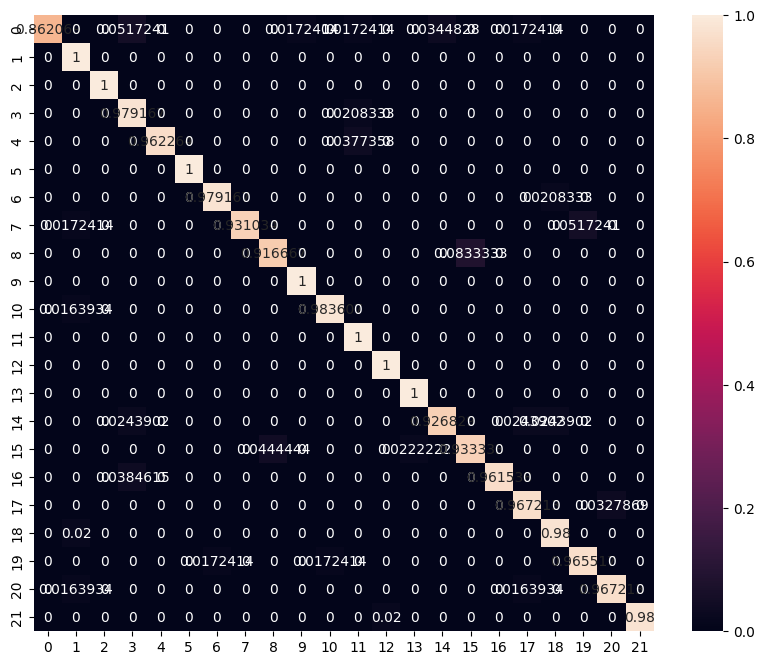

In [16]:
cm = confusion_matrix(np.array(y_test_list),np.array(y_pred_list))
cm = cm/cm.sum(axis=1)[:,None]
confusion_matrix_df = pd.DataFrame(cm)
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix_df, annot=True, fmt='g')

In [17]:
print(classification_report(y_test_list, y_pred_list, digits=4))


              precision    recall  f1-score   support

           0     1.0000    0.8621    0.9259        58
           1     0.9091    1.0000    0.9524        40
           2     1.0000    1.0000    1.0000        51
           3     0.8868    0.9792    0.9307        48
           4     1.0000    0.9623    0.9808        53
           5     1.0000    1.0000    1.0000        41
           6     0.9792    0.9792    0.9792        48
           7     1.0000    0.9310    0.9643        58
           8     0.9649    0.9167    0.9402        60
           9     0.9808    1.0000    0.9903        51
          10     0.9836    0.9836    0.9836        61
          11     0.9322    1.0000    0.9649        55
          12     0.9815    1.0000    0.9907        53
          13     0.9750    1.0000    0.9873        39
          14     0.9500    0.9268    0.9383        41
          15     0.8936    0.9333    0.9130        45
          16     1.0000    0.9615    0.9804        52
          17     0.9516    

In [22]:
def resunmetrain(model=None, criterion=None, optimizer=None, train_loader=None, test_loader=None,epochs=64,
    train_loss = [],
    train_acc = [],
    val_loss = [],
    val_acc = [],
    conf_mats = []):
    total_step = len(train_loader)
    val_loss_min = 1
    bar = tqdm(range(epochs))
    for epoch in bar:
        acc = []
        correct = 0
        total = 0  
        # Training step
        for i, (signal, labels) in enumerate(train_loader):
            signal = signal.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(signal)

            loss = criterion(outputs, labels)


            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, outputs = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (labels == outputs).sum() 
            acc.append((correct/total).item())

        #print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Acc: {:.4f}".format(epoch+1, epochs, i+1, total_step, loss.item(), np.mean(acc)))
        train_loss.append(loss.item())
        train_acc.append(np.mean(acc))

        # Validation step
        correct = 0
        total = 0  
        v_loss = []
        v_acc = []
        confusion_matrix = torch.zeros(22, 22)
        for signal, labels in test_loader:
            signal = signal.to(device)
            labels = labels.to(device)
            predictions = model(signal)
            _, predicted = torch.max(predictions, 1)
            total += labels.size(0) 
            correct += (labels == predicted).sum() 
            loss = criterion(predictions, labels)
            v_loss.append(loss.item())
            v_acc.append((correct/total).item())

            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            conf_mats.append(confusion_matrix)

        bar.set_postfix({'\033[91m Val Loss:': np.mean(v_loss), '\033[92m Val Acc:': float(correct/total),"\033[0m \n":""})
        #print('\033[91m Val Loss: '+str(np.mean(v_loss)), '\033[92m  Val Acc: '+ str(correct/total), "")

        val_acc.append((correct/total).item())
        val_loss.append(np.mean(v_loss))

        
        train_history = {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'confusion_matrix':conf_mats
        }


    return train_history, model

In [23]:
modelbackup = model

In [27]:
t_h, model = resunmetrain(model=model, criterion=criterion, optimizer=adam_belief, epochs=10, train_loader=train_loader, test_loader=test_loader,
    train_loss = t_h['train_loss'],
    train_acc = t_h['train_acc'],
    val_loss = t_h['val_loss'],
    val_acc = t_h['val_acc'],
    conf_mats = t_h['confusion_matrix'])

  0%|          | 0/10 [00:56<?, ?it/s,  Val Loss:=0.0996,  Val Acc:=0.982,  
 10%|█         | 1/10 [00:56<08:30, 56.75s/it,  Val Loss:=0.0996,  Val Acc:=0.982,  
 10%|█         | 1/10 [01:53<08:30, 56.75s/it,  Val Loss:=0.103,  Val Acc:=0.982,  
 20%|██        | 2/10 [01:53<07:32, 56.52s/it,  Val Loss:=0.103,  Val Acc:=0.982,  
 20%|██        | 2/10 [02:49<07:32, 56.52s/it,  Val Loss:=0.0994,  Val Acc:=0.982,  
 30%|███       | 3/10 [02:49<06:34, 56.33s/it,  Val Loss:=0.0994,  Val Acc:=0.982,  
 30%|███       | 3/10 [03:45<06:34, 56.33s/it,  Val Loss:=0.102,  Val Acc:=0.982,  
 40%|████      | 4/10 [03:45<05:38, 56.45s/it,  Val Loss:=0.102,  Val Acc:=0.982,  
 40%|████      | 4/10 [04:42<05:38, 56.45s/it,  Val Loss:=0.1,  Val Acc:=0.982,  
 50%|█████     | 5/10 [04:42<04:42, 56.48s/it,  Val Loss:=0.1,  Val Acc:=0.982,  
 50%|█████     | 5/10 [05:38<04:42, 56.48s/it,  Val Loss:=0.101,  Val Acc:=0.982,  
 60%|██████    | 6/10 [05:38<03:45, 56.36s/it,  Val Loss:=0.101,  Val Acc:=0.982,  


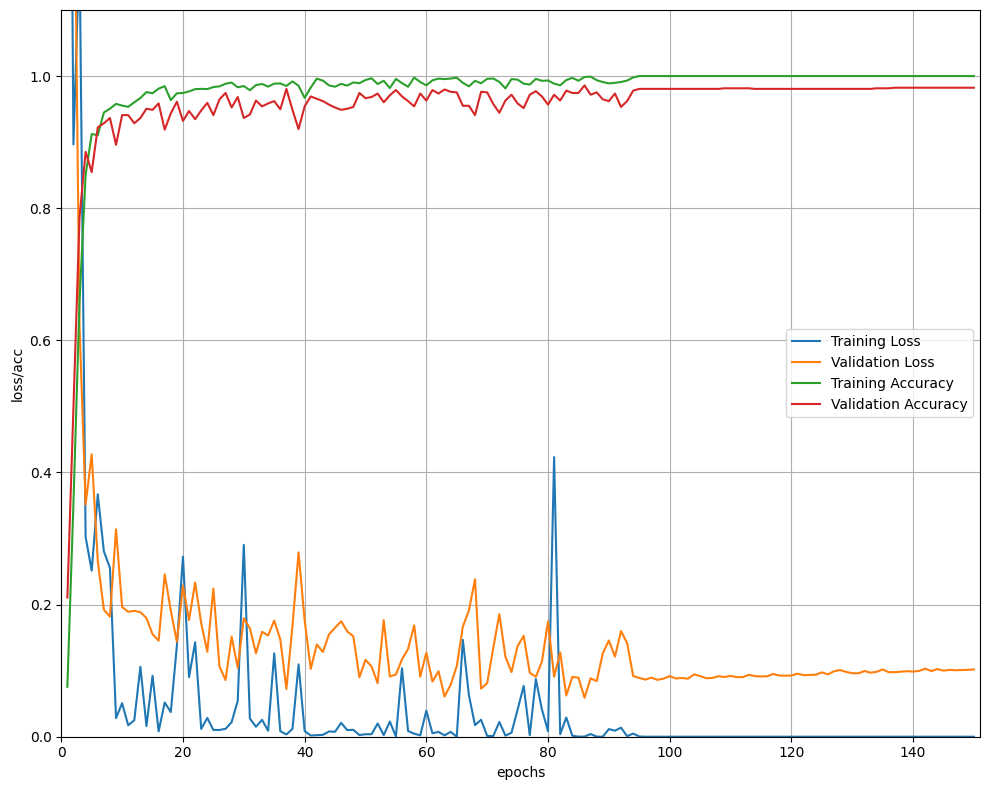

In [28]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(t_h['train_loss'])+1),t_h['train_loss'], label='Training Loss')
plt.plot(range(1,len(t_h['val_loss'])+1),t_h['val_loss'],label='Validation Loss')
plt.plot(range(1,len(t_h['train_acc'])+1),t_h['train_acc'], label='Training Accuracy')
plt.plot(range(1,len(t_h['val_acc'])+1),t_h['val_acc'],label='Validation Accuracy')


plt.xlabel('epochs')
plt.ylabel('loss/acc')
plt.ylim(0, 1.1) # consistent scale
plt.xlim(0, len(t_h['train_loss'])+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
flatten = lambda t: [item for sublist in t for item in sublist]

y_pred_list = []
y_test_list = []
with torch.no_grad():
    model.eval()
    for X_batch, y_tag in tqdm(test_loader):
        #print(y_tag.tolist())
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        #print(F.softmax(y_test_pred, dim=1))
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
        y_test_list.append(y_tag)
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_pred_list = flatten(y_pred_list)
y_test_list = flatten(y_test_list)

100%|██████████| 18/18 [00:07<00:00,  2.45it/s]


<AxesSubplot: >

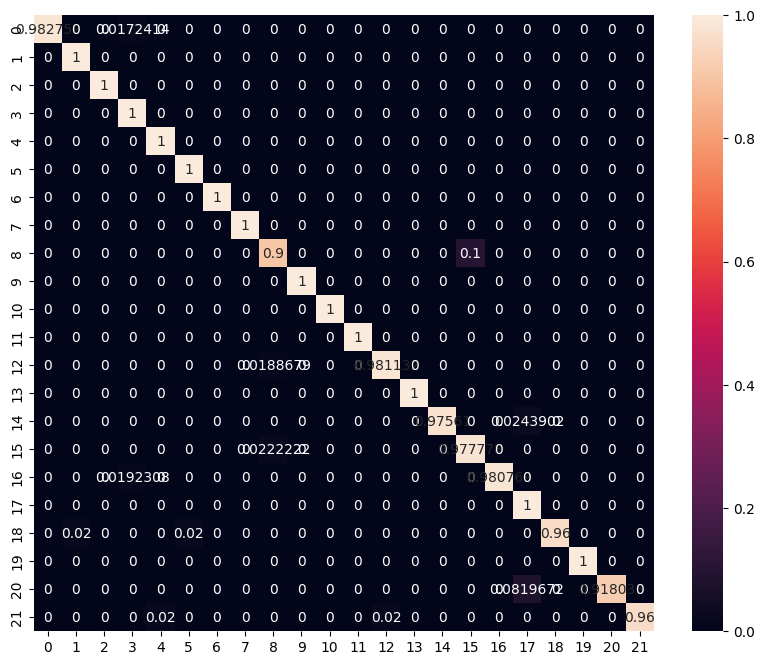

In [33]:
cm = confusion_matrix(np.array(y_test_list),np.array(y_pred_list))
cm = cm/cm.sum(axis=1)[:,None]
confusion_matrix_df = pd.DataFrame(cm)
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix_df, annot=True, fmt='g')

In [31]:
print(classification_report(y_test_list, y_pred_list, digits=4))


              precision    recall  f1-score   support

           0     1.0000    0.9828    0.9913        58
           1     0.9756    1.0000    0.9877        40
           2     1.0000    1.0000    1.0000        51
           3     0.9600    1.0000    0.9796        48
           4     0.9815    1.0000    0.9907        53
           5     0.9762    1.0000    0.9880        41
           6     1.0000    1.0000    1.0000        48
           7     1.0000    1.0000    1.0000        58
           8     0.9643    0.9000    0.9310        60
           9     1.0000    1.0000    1.0000        51
          10     1.0000    1.0000    1.0000        61
          11     1.0000    1.0000    1.0000        55
          12     0.9811    0.9811    0.9811        53
          13     1.0000    1.0000    1.0000        39
          14     1.0000    0.9756    0.9877        41
          15     0.8800    0.9778    0.9263        45
          16     1.0000    0.9808    0.9903        52
          17     0.9104    